# Forst optimization which consists in leaving out the SMOKE columns

In [17]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
%matplotlib inline


## Loading and Preprocessing Loans Encoded Data

In [18]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import os
import pandas as pd

# Set environment variables
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-1.8"
os.environ["SPARK_HOME"] = "C:/Spark/spark-3.5.3-bin-hadoop3"

# Initialize Spark session
spark = SparkSession.builder.appName("ObesityData").getOrCreate()

# Load the new dataset
df_obesity = spark.read.csv("ObesityDataSet.csv", header=True, inferSchema=True)

# Show the first few rows of the PySpark DataFrame
df_obesity.show()

# Collect the data from the PySpark DataFrame into a list of rows
data = df_obesity.collect()

# Convert the data into a list of dictionaries (each dictionary corresponds to a row)
data_dict = [row.asDict() for row in data]

# Convert the list of dictionaries into a Pandas DataFrame
df_obesity_pandas = pd.DataFrame(data_dict)

df_obesity_pandas.head()

+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0| Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                   

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [19]:
# Register the DataFrame as a temporary view
df_obesity.createOrReplaceTempView("obesity_data")

# Count total number of rows in the DataFrame with Spark SQL
query = """
SELECT COUNT(*) AS total_rows
FROM obesity_data
"""

# Execute the query and show the result
spark.sql(query).show()

+----------+
|total_rows|
+----------+
|      2111|
+----------+



In [20]:
# Define features set
X = df_obesity_pandas.copy()
X.drop(["NObeyesdad", "SMOKE", "SCC", "FAVC"], axis=1, inplace=True)
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC
0,Female,21.0,1.62,64.0,yes,2.0,3.0,Sometimes,2.0,0.0,1.0,no
1,Female,21.0,1.52,56.0,yes,3.0,3.0,Sometimes,3.0,3.0,0.0,Sometimes
2,Male,23.0,1.80,77.0,yes,2.0,3.0,Sometimes,2.0,2.0,1.0,Frequently
3,Male,27.0,1.80,87.0,no,3.0,3.0,Sometimes,2.0,2.0,0.0,Frequently
4,Male,22.0,1.78,89.8,no,2.0,1.0,Sometimes,2.0,0.0,0.0,Sometimes


In [21]:
# Define target vector
y = df_obesity_pandas["NObeyesdad"].ravel()
y[:5]

C:\Users\USER\AppData\Local\Temp\ipykernel_28144\1680875107.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = df_obesity_pandas["NObeyesdad"].ravel()


array(['Normal_Weight', 'Normal_Weight', 'Normal_Weight',
       'Overweight_Level_I', 'Overweight_Level_II'], dtype=object)

In [22]:
#One-hot encode categorical data
X = pd.get_dummies(X)
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,True,False,False,True,False,False,True,False,False,False,False,True
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,True,False,False,True,False,False,True,False,False,False,True,False
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,False,True,False,True,False,False,True,False,False,True,False,False
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,False,True,True,False,False,False,True,False,False,True,False,False
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,False,True,True,False,False,False,True,False,False,False,True,False


In [23]:
# Scale the numerical features
obesity_data_scaled = StandardScaler().fit_transform(X[["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]])

# Create a DataFrame with the scaled data
df_obesity_transformed = pd.DataFrame(
    obesity_data_scaled, columns=["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"]
)

# Show the scaled data
df_obesity_transformed.head()




,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [24]:
X.drop(["Age","Height","Weight","FCVC","NCP","CH2O","FAF","TUE"], axis=1, inplace=True)
X = pd.concat([X, df_obesity_transformed], axis=1)

X.head()

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,CAEC_Always,CAEC_Frequently,CAEC_Sometimes,CAEC_no,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,True,False,False,True,False,False,True,False,False,False,False,True,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,True,False,False,True,False,False,True,False,False,False,True,False,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,False,True,False,True,False,False,True,False,False,True,False,False,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,False,True,True,False,False,False,True,False,False,True,False,False,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,False,True,True,False,False,False,True,False,False,False,True,False,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


In [25]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

## Fitting the Random Forest Model

In [26]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

In [27]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

## Making Predictions Using the Random Forest Model

In [28]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)

## Model Evaluation

In [29]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1", "Actual 2", "Actual 3", "Actual 4", "Actual 5", "Actual 6"], columns=["Predicted 0", "Predicted 1", "Predicted 2", "Predicted 3", "Predicted 4", "Predicted 5", "Predicted 6"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6
Actual 0,68,2,0,0,0,0,0
Actual 1,5,59,0,0,0,5,0
Actual 2,0,2,92,1,0,0,3
Actual 3,0,0,0,69,0,0,0
Actual 4,0,0,0,0,72,0,0
Actual 5,0,5,1,0,0,63,4
Actual 6,0,1,1,1,0,2,72


Accuracy Score : 0.9375
Classification Report
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.97      0.95        70
      Normal_Weight       0.86      0.86      0.86        69
     Obesity_Type_I       0.98      0.94      0.96        98
    Obesity_Type_II       0.97      1.00      0.99        69
   Obesity_Type_III       1.00      1.00      1.00        72
 Overweight_Level_I       0.90      0.86      0.88        73
Overweight_Level_II       0.91      0.94      0.92        77

           accuracy                           0.94       528
          macro avg       0.94      0.94      0.94       528
       weighted avg       0.94      0.94      0.94       528



## Feature Importance

In [31]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(np.float64(0.31555123196811297), 'Weight'),
 (np.float64(0.09591061418901076), 'Age'),
 (np.float64(0.09362435165493135), 'Height'),
 (np.float64(0.08441226227742274), 'FCVC'),
 (np.float64(0.05507601963072035), 'NCP'),
 (np.float64(0.048438316093383414), 'TUE'),
 (np.float64(0.04562974177925153), 'FAF'),
 (np.float64(0.04447370972462108), 'CH2O'),
 (np.float64(0.04027186350570769), 'Gender_Male'),
 (np.float64(0.0402059090074061), 'Gender_Female'),
 (np.float64(0.022938889404388013), 'CALC_Sometimes'),
 (np.float64(0.021541064561160794), 'family_history_with_overweight_no'),
 (np.float64(0.02098206837409322), 'family_history_with_overweight_yes'),
 (np.float64(0.019611474243841413), 'CALC_no'),
 (np.float64(0.019550823786213145), 'CAEC_Sometimes'),
 (np.float64(0.01712857396685413), 'CAEC_Frequently'),
 (np.float64(0.005622776530383735), 'CAEC_no'),
 (np.float64(0.005033528353778321), 'CALC_Frequently'),
 (np.float64(0.0039336339467406925), 'CAEC_Always'),
 (np.float64(6.31470019785

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

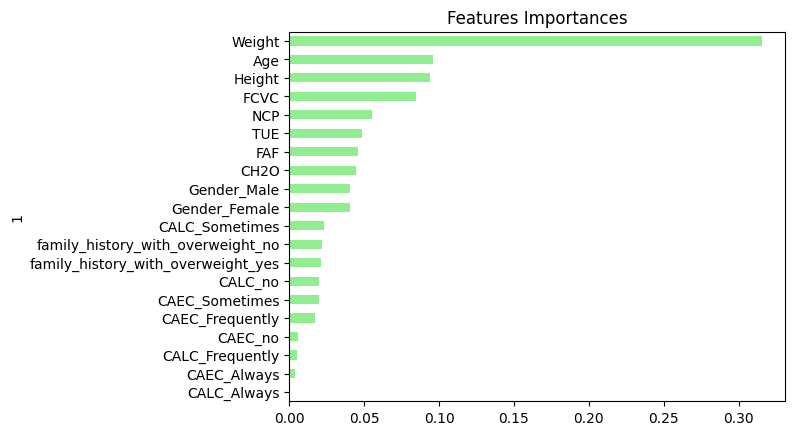

In [32]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)